We load the libraies needed for the deblurring

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter
from keras.layers import Conv2D, BatchNormalization, Activation, Lambda, Dense, Input, MaxPooling2D, UpSampling2D, concatenate, Add
from keras.models import Model, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K
from keras.layers.convolutional import Convolution2D
import random
import glob as gb
import h5py
from tqdm import tqdm
from PIL import Image
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dropout, Dense, Flatten, Lambda
from keras.layers.merge import Average
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import matplotlib.pyplot as plt
from os.path import dirname, join
import imageio



Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Download the dataset from the official site

In [ ]:
!wget https://cv.snu.ac.kr/~snah/Deblur/dataset/REDS/val_blur.zip
!wget https://cv.snu.ac.kr/~snah/Deblur/dataset/REDS/test_blur.zip
!wget https://cv.snu.ac.kr/~snah/Deblur/dataset/REDS/val_sharp.zip

unizip the compressed files containing sharp and blurred images

In [ ]:
!unzip val_blur.zip
!unzip val_sharp.zip

We load the images as numpy array to pass them to the neural network for training: we resize them to a lower dimension 500x500x3 then normalize them to the format supported by the vgg16 network

In [ ]:
train_names_x = []
train_names_y = []
for path, sub,files in os.walk('val/val_sharp'):
    for name in files:
        train_names_y.append(os.path.join(path, name))
for path, sub, files in os.walk('val/val_blur'):
    for name in files:
        train_names_x.append(os.path.join(path, name))

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

train_x = np.ndarray(shape=(len(train_names_x), 500,500, 3), dtype=np.float32)
train_y = np.ndarray(shape=(len(train_names_y), 500,500, 3), dtype=np.float32)
i = 0
for file in train_names_x:
    img = load_img(file)  # this is a PIL image
    print(file)
    img = img.resize((500,500))
    # Convert to Numpy Array
    x = img_to_array(img)  
    # Normalize
    x = x / 127.5 - 1
    train_x[i] = x
    i += 1
i = 0
for file in train_names_y:
    img = load_img(file)  # this is a PIL image
    print(file)
    img = img.resize((500,500))
    # Convert to Numpy Array
    x = img_to_array(img)
    # Normalize
    x = x / 127.5 - 1
    train_y[i] = x
    i += 1

hyper parameters of the network

In [ ]:
K_1 = 145
K_2 = 170
channel_rate = 64
patch_shape = (channel_rate, channel_rate, 3)
ngf = 64
ndf = 64
n_blocks_gen = 9
input_nc = 3
output_nc = 3
image_shape = (500, 500, input_nc)
input_shape_generator = image_shape
input_shape_discriminator = (500, 500, output_nc)

Loss functions for the generator, discriminaror and the global model

In [ ]:
def lossL1(yTrue, yPred):
    return K.mean(K.abs(yPred - yTrue))
def lossPerceptual(yTrue, yPred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
    lossModel = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    lossModel.trainable = False
    return K.mean(K.square(lossModel(yTrue) - lossModel(yPred)))
def lossGenerator(yTrue, yPred):
    return K_1 * lossPerceptual(yTrue, yPred) + K_2 * lossL1(yTrue, yPred)
def lossAdversarial(yTrue, yPred):
    return -K.log(yPred)

Utils used for the generator model building
###Credits goes to https://github.com/RaphaelMeudec/deblur-gan

In [ ]:

#####Credits goes to https://github.com/RaphaelMeudec/deblur-gan


def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), use_dropout=False):
    x = ReflectionPadding2D((1, 1))(input)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if use_dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(x)
    x = BatchNormalization()(x)

    merged = Add()([input, x])
    return merged


def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):

    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2
    if data_format is None:
        data_format = image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if data_format == 'channels_first':
        pattern = [[0, 0],
                   [0, 0],
                   list(padding[0]),
                   list(padding[1])]
    else:
        pattern = [[0, 0],
                   list(padding[0]), list(padding[1]),
                   [0, 0]]
    return tf.pad(x, pattern, "REFLECT")


class ReflectionPadding2D(Layer):
    def __init__(self,
                 padding=(1, 1),
                 data_format=None,
                 **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, '__len__'):
            if len(padding) != 2:
                raise ValueError('`padding` should have two elements. '
                                 'Found: ' + str(padding))
            height_padding = conv_utils.normalize_tuple(padding[0], 2,
                                                        '1st entry of padding')
            width_padding = conv_utils.normalize_tuple(padding[1], 2,
                                                       '2nd entry of padding')
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError('`padding` should be either an int, '
                             'a tuple of 2 ints '
                             '(symmetric_height_pad, symmetric_width_pad), '
                             'or a tuple of 2 tuples of 2 ints '
                             '((top_pad, bottom_pad), (left_pad, right_pad)). '
                             'Found: ' + str(padding))
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    input_shape[1],
                    rows,
                    cols)
        elif self.data_format == 'channels_last':
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    rows,
                    cols,
                    input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(inputs,
                                             padding=self.padding,
                                             data_format=self.data_format)

    def get_config(self):
        config = {'padding': self.padding,
                  'data_format': self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Building the generator model that uses convolution layers and generates fake images from the ones passed as input

In [ ]:
def generatorModel():
    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding='valid')(x)
    x = Activation('tanh')(x)

    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model


The discriminator model that uses convolution layers and flatten the output to get a probability value that indicated whether the input is a real image or a fake one

In [ ]:
def discriminatorModel():
    in_dis = Input(shape=patch_shape)
    x = Convolution2D(filters=channel_rate, kernel_size=(3, 3), strides=(2, 2), padding="same")(in_dis)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Convolution2D(filters=2 * channel_rate, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Convolution2D(filters=4 * channel_rate, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Convolution2D(filters=4 * channel_rate, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    out_dis = Dense(units=1, activation='sigmoid')(x)
    model = Model(inputs=in_dis, outputs=out_dis, name='Discriminator')

    inputs = Input(shape=image_shape)

    list_row_idx = [(i * channel_rate, (i + 1) * channel_rate) for i in
                    range(int(image_shape[0] / patch_shape[0]))]
    list_col_idx = [(i * channel_rate, (i + 1) * channel_rate) for i in
                    range(int(image_shape[1] / patch_shape[1]))]

    list_patch = []
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(inputs)
            list_patch.append(x_patch)

    x = [model(patch) for patch in list_patch]
    outputs = Average()(x)
    model = Model(inputs=inputs, outputs=outputs, name='Discriminator')
    return model

The concatenation of the discriminator and generator models to alternate between their backpropagation while training.
The result is a new GAN model that regroups the two

In [ ]:
def generatorWithDiscriminator(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=outputs)
    return model

For the training we compile the 3 models, then at each iteration we compute the loss of the discriminator, correct its weights, do the same for the generator

In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json

def train(xTrain, yTrain, batch_size, epoch_num):

    g = generatorModel()
    d = discriminatorModel()


    g.compile(optimizer='adam', loss=lossGenerator)
    d.compile(optimizer='adam', loss='binary_crossentropy')

    d_on_g = generatorWithDiscriminator(g, d)

    d_on_g.compile(optimizer='adam', loss=lossAdversarial)

    for epoch in range(epoch_num):
        print('epoch: ', epoch + 1, '/', epoch_num)
        for index in range(int(xTrain.shape[0] / batch_size)):
            bImageBatch = xTrain[index * batch_size:(index + 1) * batch_size]
            fImageBatch = yTrain[index * batch_size:(index + 1) * batch_size]
            gImages = g.predict(x=bImageBatch, batch_size=batch_size)

            x = np.concatenate((fImageBatch, gImages))

            y = [1] * batch_size + [0] * batch_size

            dLoss = d.train_on_batch(x, y)
            print('batch %d d_loss : %f' % (index + 1, dLoss))

            d.trainable = False

            d_on_gLoss = d_on_g.train_on_batch(bImageBatch, [1] * batch_size)
            print('batch %d d_on_g_loss : %f' % (index + 1, d_on_gLoss))

            gLoss = g.train_on_batch(bImageBatch, fImageBatch)
            print('batch %d g_loss : %f' % (index + 1, gLoss))

            d.trainable = True

            if (index % 100 == 0) and (index != 0):
                g.save_weights('drive/My Drive/generator_weights.h5')
                d.save_weights('drive/My Drive/discriminator_weights.h5')

We train with batches of 2 images and for 200 epochs

!!! Couldn't increase the batch size and the number of epochs ( also the number of the training set because of the limitations imposed by google colab)

In [ ]:
train(train_x, train_y, batch_size=2, epoch_num=200)

# Testing

unzip the testing set with blurry images

In [ ]:
!unzip test_blur.zip

get the arrays from the images files like we did with the training set

In [ ]:
test_names_x = []
for path, subdirs, files in os.walk('test/test_blur'):
    for name in files:
        test_names_x.append(os.path.join(path, name))

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

test_x = np.ndarray(shape=(len(test_names_x), 500,500, 3), dtype=np.float32)
i = 0
for _file in test_names_x:
    img = load_img(_file)  # this is a PIL image
    img = img.resize((500,500))
    # Convert to Numpy Array
    x = img_to_array(img)  
    # Normalize
    x = x / 127.5 - 1
    test_x[i] = x
    i += 1

load the weights of the trained generator

In [ ]:
g = generatorModel()
g.load_weights('drive/My Drive/generator_weights.h5')

select random images from the test set

In [ ]:
ids = np.random.randint(0, len(test_x), 10)
samples = test_x[ids]

Apply the model to the blurry images

In [ ]:
gImages = g.predict(x=samples)
generated = gImages * 127.5 + 127.5

plot the results

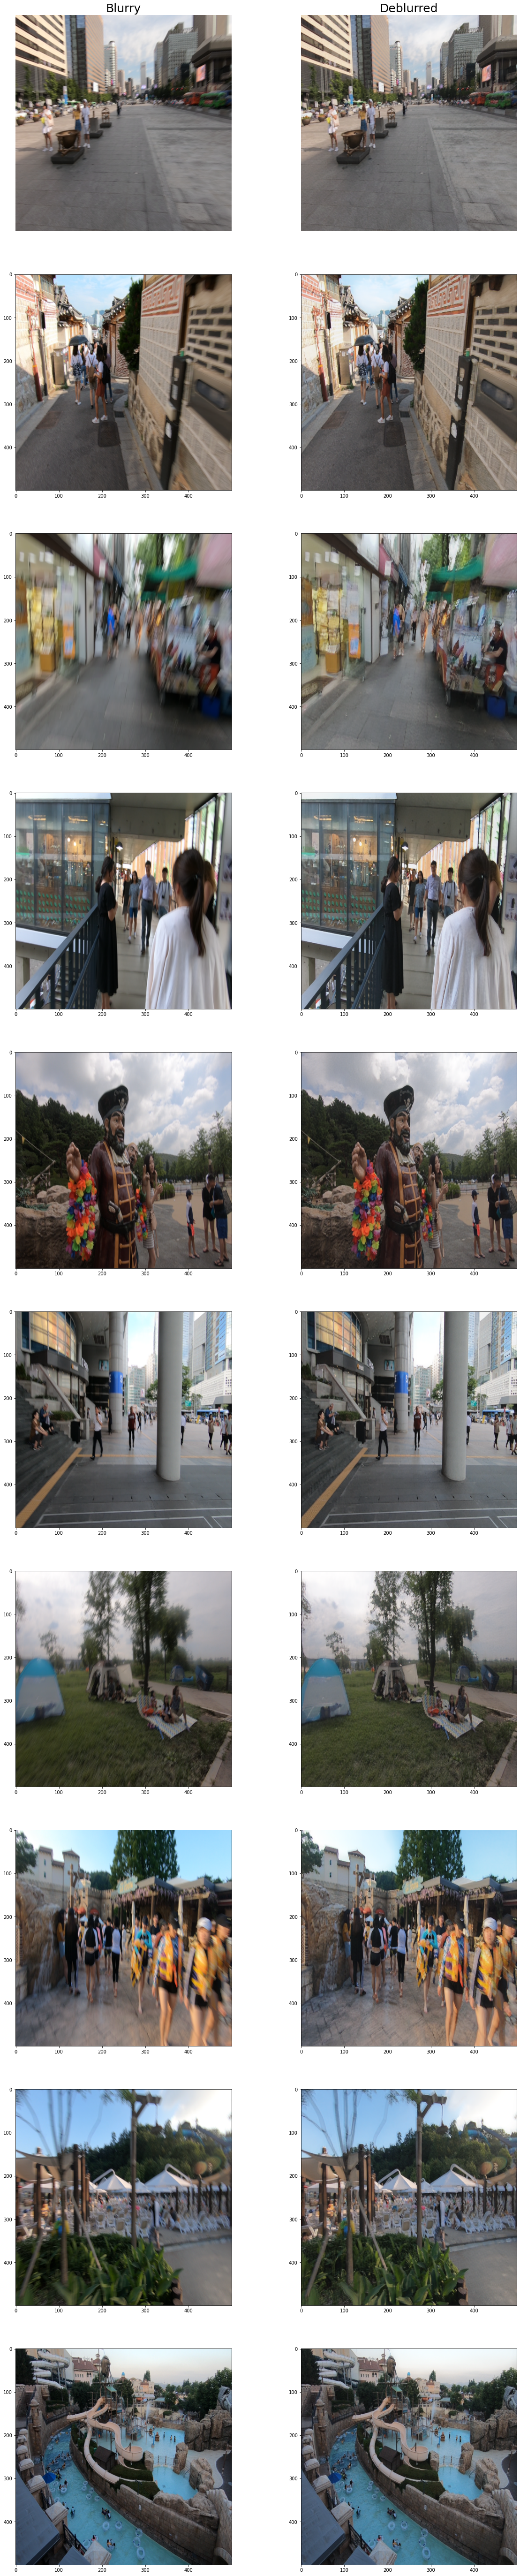

In [4]:
f, ax = plt.subplots(10,2, figsize=(20,100))
for i in range(10):
    ax[i,0].imshow((test_x[ids[i]]* 127.5 + 127.5).astype(np.uint8));  ax[i,0].axis('Off'); ax[i,0].set_title('Blurry', size=25)
    ax[i,1].imshow(generated[i].astype(np.uint8));  ax[i,1].axis('Off'); ax[i,1].set_title('Deblurred', size=25)
plt.show()